



#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계2 : 모델링

## 0.미션

* 다음 두가지 챗봇을 만들고 비교해 봅시다.
* 챗봇1. Word2Vec 임베딩 벡터 기반 머신러닝 분류 모델링
    * Word2Vec 모델을 만들고 임베딩 벡터를 생성합니다.
    * 임베딩 벡터를 이용하여 intent를 분류하는 모델링을 수행합니다.
        * 이때, LightGBM을 추천하지만, 다른 알고리즘을 이용할수 있습니다.
    * 예측된 intent의 답변 중 임의의 하나를 선정하여 출력합니다.
* 챗봇2. 단계별 모델링1
    * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
        * Embedding + LSTM 모델링
    * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
    * 3단계 : 코사인 유사도로 intent 찾아 답변 출력
        * 새로운 문장의 임베딩벡터와 train의 임베딩 벡터간의 코사인 유사도 계산
        * 가장 유사도가 높은 질문의 intent를 찾아 답변 출력하기

* 챗봇 2개에 대해서 몇가지 질문을 입력하고 각각의 답변을 비교해 봅시다.


## 1.환경준비

### (1)라이브러리 설치

#### 1) gensim 설치

In [1]:
#gensim은 자연어 처리를 위한 오픈소스 라이브러리입니다. 토픽 모델링, 워드 임베딩 등 다양한 자연어 처리 기능을 제공
!pip install gensim

#### 2) 형태소 분석을 위한 라이브러리

In [2]:
# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython
!pip install mecab-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
curl is already the newest version (7.81.0-1ubuntu1.14).
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
g++ is already the newest version (4:11.2.0-1ubuntu1).
g++ set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
B

In [3]:
# 형태소 기반 토크나이징 (Konlpy)
!python3 -m pip install konlpy
# mecab (ubuntu: linux, mac os 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
!pip install mecab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 47.0 MB/s eta 0:00:00
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   491k      0  0:00:02  0:00:02 --:--:-- 1255k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/example.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.c
mecab-0.996-ko-0.9.2/example/example.c
mecab-0.996-ko-0.9.2/example/thread_test.cpp
mecab-0.996-ko-0.9.2/mecab-config.in
mecab-0.996-ko-0.9.2/man/
mecab-0.996-ko-0.9.2/man/Makefile.am
mecab-0.996-ko-0.9.2/man/mecab.1
mecab-0.996-ko-0.9.2/man/Makefile.in
mecab-0.996-ko-0.9.2/mecab.iss.in
mecab-0.996-ko-0.9.2/confi

### (2) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import *

import tensorflow as tf
from keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout, Flatten
from keras import Input, Model
from keras import optimizers
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
pd.set_option('display.max_colwidth', None)  # None으로 설정하면 문자열이 잘리지 않고 전체가 출력됩니다.

In [6]:
# 시각화 한글폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumGothic')
sns.set(font="NanumGothic",#"NanumGothicCoding",
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,717 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121080 files and dire

In [7]:
# 모든 행 출력
pd.set_option('display.max_rows', None)

# 모든 열 출력
pd.set_option('display.max_columns', None)

* 형태소 분석을 위한 함수를 제공합니다.

In [8]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

# 다양한 토크나이저를 사용할 수 있는 함수
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        # "kkma":
        tokenizer = Kkma()

    return tokenizer

In [9]:
# 형태소 분석을 수행하는 함수
def tokenize(tokenizer_name, original_sent, nouns=False):
    # 미리 정의된 몇 가지 tokenizer 중 하나를 선택
    tokenizer = get_tokenizer(tokenizer_name)

    # tokenizer를 이용하여 original_sent를 토큰화하여 tokenized_sent에 저장하고, 이를 반환합니다.
    sentence = original_sent.replace('\n', '').strip()
    if nouns:
        # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.nouns(sentence)
    else:
        tokens = tokenizer.morphs(sentence)
    tokenized_sent = ' '.join(tokens)

    return tokenized_sent

### (3) 데이터 로딩
* 전처리 단계에서 생성한 데이터들을 로딩합니다.
    * train, test
    * 형태소분석 결과 데이터 : clean_train_questions, clean_test_questions
* Google Colab 환경에서 진행을 권장합니다.
    * 구글 드라이브 바로 밑에 project 폴더를 만들고,
    * 데이터 파일을 복사해 넣습니다.

#### 1) Google Colab 환경 구축

* 구글 드라이브 연결

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
#ex : path = '/content/drive/MyDrive/project/'
path = '/content/drive/MyDrive/미니프로젝트6차part1/데이터'

#### 2) 저장된 데이터 읽어오기
* 저장된 .pkl 파일들을 불러옵니다.
* 불러 온 후에는 shape를 확인해 봅시다.

In [12]:
df = joblib.load(f'{path}/df.joblib')

In [13]:
train_df = joblib.load(f'{path}/train_df.joblib')
test_df = joblib.load(f'{path}/test_df.joblib')

In [14]:
clean_train_questions = joblib.load(f'{path}/clean_train_questions.joblib')
clean_test_questions = joblib.load(f'{path}/clean_test_questions.joblib')

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   intent  1192 non-null   int64 
 1   Q       1192 non-null   object
 2   A       1192 non-null   object
 3   type    1192 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 37.4+ KB


In [16]:
test_df.info() # 여긴 왜 모두 object로 되어있는지 모르겠다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   intent  106 non-null    object
 1   Q       106 non-null    object
 2   A       106 non-null    object
 3   type    106 non-null    object
dtypes: object(4)
memory usage: 3.4+ KB


<h3> intent에 따른 Answer를 정의한다. </h3>

## 2.챗봇1

* **상세요구사항**
    * Word2Vec을 활용한 LightGBM 모델링(intent 분류)
        * Word2Vec을 이용하여 임베딩벡터 생성하기
            * Word Embedding으로 문장벡터 구하기
        * 임베딩 벡터를 이용하여 ML기반 모델링 수행하기
            * LightGBM 권장(다른 알고리즘을 이용할수 있습니다.)
    * 챗봇 : 모델의 예측결과(intent)에 따라 답변하는 챗봇 만들기
        * 질문을 입력받아, 답변하는 함수 생성

### (1) Word2Vec을 이용하여 임베딩벡터 생성하기
* 'mecab' 형태소 분석기를 이용하여 문장을 tokenize
    * Word2Vec 모델을 만들기 위해서 입력 데이터는 리스트 형태여야 합니다.
    * 그래서 다시 리스트로 저장되도록 토크나이즈 해 봅시다.
* Word Embedding으로 문장벡터를 생성합니다.
    * 먼저 Word2Vec 모델을 만들고, train의 질문들을 문장벡터로 만듭시다.


#### 1) 'mecab' 형태소 분석기를 이용하여 문장을 tokenize

* clean_train_questions와 clean_test_questions는
2차원 리스트로 표현해야 한다. 왜 다 이유가 있다.<br>
get_dataset() 함수를 사용할 때 1번째 매개변수로 얘네를 줄텐데 그 떄 기대하는 형식이 2차원 리스트이기 떄문이다.<br> 그래서 이 작업을 미리하는 것이다.

In [17]:
clean_train_questions.head() # 이것들을 2차원 리스트 형태로 변환해야 한다?

0    떨어뜨려서 핸드폰 액정 나갔어
1              액정 나갔어
2     핸드폰 떨어뜨려서 고장 났나
3        노트북 키 보드 먹히네
4          노트북 전원 들어와
Name: Q, dtype: object

In [18]:
# Okt 형태소 분석기 초기화
okt = Okt()

In [19]:
# 시리즈를 리스트로 변환하고 토큰화 -> 2차원 리스트임을 알 수 있다.
clean_train_questions = [okt.morphs(sentence) for sentence in clean_train_questions]

In [20]:
clean_train_questions

[['떨어뜨려서', '핸드폰', '액정', '나갔어'],
 ['액정', '나갔어'],
 ['핸드폰', '떨어뜨려서', '고장', '났나'],
 ['노트북', '키', '보드', '먹히네'],
 ['노트북', '전원', '들어와'],
 ['노트북', '떨어뜨려서', '고장', '난', '같아'],
 ['컴퓨터', '제대로', '작동', '하지', '않아요'],
 ['컴퓨터', '에러', '메시지', '띄우고', '있어요'],
 ['컴터', '고장', '났나'],
 ['컴터', '맛', '갔어'],
 ['컴터', '돼'],
 ['핸드폰', '고장', '났나'],
 ['핸드폰', '돼'],
 ['노트북', '돼'],
 ['의지', '는', '상관없나'],
 ['의지', '안되는', '일인', '가봐'],
 ['건강', '최고'],
 ['아프면', '되는데'],
 ['올해', '도', '건강하길'],
 ['올해', '도', '행복하길'],
 ['올해', '취업', '하길'],
 ['올해', '합격', '하길'],
 ['건강', '최고'],
 ['올해', '는', '꼭', '취업', '할거야'],
 ['년도', '는', '꼭', '장만', '할거야'],
 ['여자친구', '사귀고', '싶어'],
 ['하는', '찾고', '싶어'],
 ['좋아하는', '은', '인지', '찾아볼려고'],
 ['비', '맞아서', '옷', '젖었어'],
 ['옷', '다', '젖었어'],
 ['코맹맹'],
 ['동상', '걸릴', '뻔했어'],
 ['동상', '걸릴거', '같아'],
 ['바람', '많이', '부네'],
 ['바람', '너무', '많이', '부네'],
 ['보다', '오늘', '너무', '춥네'],
 ['놔', '코', '막혀'],
 ['얼어', '죽는', '줄'],
 ['얼어', '죽는', '줄'],
 ['오늘', '보다', '춥네'],
 ['추워', '죽', '뻔했네'],
 ['추워', '죽겠다'],
 ['코', '막혀'],
 ['비', '맞아서', '옷', '젖었어'

In [22]:
# 시리즈를 리스트로 변환하고 토큰화 -> 2차원 리스트임을 알 수 있다.
clean_test_questions = [okt.morphs(sentence) for sentence in clean_test_questions]

In [23]:
clean_train_questions[0:5:1] # Word2Vec를 만들기 위해 2차원 리스트 형태로 되어있는 것을 확인할 수 있다.

[['떨어뜨려서', '핸드폰', '액정', '나갔어'],
 ['액정', '나갔어'],
 ['핸드폰', '떨어뜨려서', '고장', '났나'],
 ['노트북', '키', '보드', '먹히네'],
 ['노트북', '전원', '들어와']]

#### 2) Word Embedding으로 문장벡터 구하기
* Word2Vec
    * 위에서 저장한 입력 데이터를 사용하여 Word2Vec 모델이 생성
    * 모델은 size(단어 벡터의 차원),
    * window(컨텍스트 창의 크기),
    * max_vocab_size(고려할 최대 어휘 크기),
    * min_count(포함할 단어의 최소 빈도)와 같은 특정 하이퍼파라미터로 훈련됩니다.
    * sg : 사용할 훈련 알고리즘 - 1은 skip-gram, 0은 CBOW )

* Word2Vec 모델에 활용되는 매개변수를 정의합시다!

In [24]:
SIZE = 100
WINDOW = 5
MIN_COUNT = 1
WORKERS = 4

In [25]:
from gensim.models import Word2Vec

# Word2Vec 모델 생성
wv_model = Word2Vec(sentences=clean_train_questions, # 1번째 매개변수로 2차원 리스트를 기대한다.
                    vector_size=SIZE,
                    window=WINDOW,
                    min_count=MIN_COUNT,
                    workers=WORKERS,
                    sg=0, )

* Word2Vec 모델로부터 데이터를 벡터화하기 위한 함수 생성

In [26]:
# Word2Vec 모델로부터 하나의 문장을 벡터화 시키는 함수 생성
def get_sent_embedding(model, embedding_size, tokenized_words):
    # 임베딩 벡터를 0으로 초기화
    feature_vec = np.zeros((embedding_size,), dtype='float32')
    # 단어 개수 초기화
    n_words = 0
    # 모델 단어 집합 생성
    index2word_set = set(model.wv.key_to_index.keys())
    # 문장의 단어들을 하나씩 반복
    for word in tokenized_words:
        # 모델 단어 집합에 해당하는 단어일 경우에만
        if word in index2word_set:
            # 단어 개수 1 증가
            n_words += 1
            # 임베딩 벡터에 해당 단어의 벡터를 더함
            feature_vec = np.add(feature_vec, model.wv.get_vector(word))
    # 단어 개수가 0보다 큰 경우 벡터를 단어 개수로 나눠줌 (평균 임베딩 벡터 계산)
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [27]:
# 문장벡터 데이터 셋 만들기
def get_dataset(sentences, model, num_features):
    dataset = list()

    # 각 문장을 벡터화해서 리스트에 저장
    for sent in sentences:
        dataset.append(get_sent_embedding(model, num_features, sent))

    # 리스트를 numpy 배열로 변환하여 반환
    sent_embedding_vectors = np.stack(dataset)

    return sent_embedding_vectors

* 이제 학습데이터의 Q를 Word2Vec 모델을 사용하여 벡터화 합니다.

In [28]:
# 학습 데이터의 문장들을 Word2Vec 모델을 사용하여 벡터화
train_data_vecs = get_dataset(sentences=clean_train_questions, model=wv_model, num_features=100) # 1번쨰 매개변수는 2차원 리스트를 기대한다.

* 언제나 get_dataset() 함수를 사용하면 2차원 넘파이 배열이다. 왜냐하면 코드에서 return 할떄 2차원 넘파이 배열이기 떄문

* 훈련된 Word2Vec 모델을 사용하여 문장 목록에 대한 문장 임베딩을 생성하고 이를 2차원 numpy 배열에 저장합니다.
* 그런 다음 이러한 임베딩을 다양한 기계 학습 모델의 입력 기능으로 사용할 수 있습니다

In [29]:
train_data_vecs # Word2Vec 모델로부터 학습 데이터를 벡터화 한 결과 입니다.

array([[ 0.00188884,  0.00409556,  0.00337401, ..., -0.0039295 ,
         0.00452117,  0.0008851 ],
       [ 0.00155076,  0.00153275,  0.00029263, ...,  0.00080626,
         0.0028481 ,  0.00539704],
       [-0.0017958 ,  0.00391856, -0.001328  , ..., -0.00570017,
        -0.00020655,  0.0002442 ],
       ...,
       [-0.00752427,  0.01470243,  0.00470035, ..., -0.01843934,
         0.00071943, -0.00453997],
       [-0.00404422,  0.0055398 ,  0.00066577, ..., -0.00553379,
         0.00169501, -0.00131452],
       [-0.0063858 ,  0.00674818,  0.00355475, ..., -0.01261365,
        -0.00032547,  0.00294473]], dtype=float32)

In [30]:
train_data_vecs.shape # 우리 shape도 찍어봐요

(1192, 100)

### (2) 분류 모델링
* 데이터 분할
    * x, y
        * x : 이전 단계에서 저장된 임베딩벡터
        * y : intent 값들
    * train, val
        * train_test_split 활용
* 머신러닝 모델링
    * lightGBM, RandomForest 등을 활용하여 학습
    * 필요하다면 hyper parameter 튜닝을 시도해도 좋습니다.
* validation set으로 검증해 봅시다.

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
# X와 y 데이터 분리
X = train_data_vecs
y = train_df['intent']

# Train-Test split
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, stratify=y, random_state=76)

In [33]:
print(train_X.shape, val_X.shape, train_y.shape, val_y.shape)

(953, 100) (239, 100) (953,) (239,)


* 머신러닝, 딥러닝 돌릴 떄 X는 2차원 넘파이 배열 or 데이터프레임 형태면 되고
  Y는 1차원 넘파이 배열 or 시리즈(Series)이면 된다.

<h4> 모델 1(LightGBM), 모델 2(RandomForest)를 사용하기 앞서<br> Target 소수 클래스에 대해서 가중치를 더 부여하는 방법을 사용한다. </h4>

In [37]:
train_y.value_counts()

32    109
8      53
50     46
46     46
39     46
41     30
43     30
45     30
3      30
31     30
40     30
20     26
30     22
28     21
21     18
13     18
47     14
52     14
44     14
48     14
36     14
34     14
51     14
33     14
38     14
35     14
53     14
49     14
42     13
29     13
37     13
2      11
1      11
27     10
26      9
4       7
22      7
23      7
18      7
15      7
24      7
25      7
9       7
7       7
11      7
10      7
17      7
14      6
6       6
5       6
16      6
12      6
19      6
Name: intent, dtype: int64

In [34]:
from sklearn.utils.class_weight import compute_class_weight

In [35]:
# 클래스 레이블과 해당 레이블의 빈도수
labels = np.unique(train_y)
class_weight = compute_class_weight(class_weight='balanced', classes=labels, y=train_y)

# 클래스 가중치 딕셔너리 생성
class_weight_dict = {label: weight for label, weight in zip(labels, class_weight)}

In [36]:
class_weight_dict # 비교적 소수 클래스를 가중치 더 부여하는 것으로 알 수 있다.

{1: 1.634648370497427,
 2: 1.634648370497427,
 3: 0.5993710691823899,
 4: 2.568733153638814,
 5: 2.99685534591195,
 6: 2.99685534591195,
 7: 2.568733153638814,
 8: 0.3392666429334283,
 9: 2.568733153638814,
 10: 2.568733153638814,
 11: 2.568733153638814,
 12: 2.99685534591195,
 13: 0.9989517819706499,
 14: 2.99685534591195,
 15: 2.568733153638814,
 16: 2.99685534591195,
 17: 2.568733153638814,
 18: 2.568733153638814,
 19: 2.99685534591195,
 20: 0.6915820029027576,
 21: 0.9989517819706499,
 22: 2.568733153638814,
 23: 2.568733153638814,
 24: 2.568733153638814,
 25: 2.568733153638814,
 26: 1.9979035639412999,
 27: 1.7981132075471697,
 28: 0.8562443845462714,
 29: 1.3831640058055152,
 30: 0.8173241852487135,
 31: 0.5993710691823899,
 32: 0.16496451445386878,
 33: 1.284366576819407,
 34: 1.284366576819407,
 35: 1.284366576819407,
 36: 1.284366576819407,
 37: 1.3831640058055152,
 38: 1.284366576819407,
 39: 0.39089417555373257,
 40: 0.5993710691823899,
 41: 0.5993710691823899,
 42: 1.383164

* 모델1 (LightGBM)

In [38]:
import lightgbm as lgb

In [39]:
# LightGBM 분류기 생성
lgbmC = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=53,
    learning_rate=0.05,
    n_estimators=100,
    num_leaves=31,
    class_weight= class_weight_dict,
)

# 학습
lgbmC.fit(train_X, train_y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25499
[LightGBM] [Info] Number of data points in the train set: 953, number of used features: 100
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM

LGBMClassifier(class_weight={1: 1.634648370497427, 2: 1.634648370497427,
                             3: 0.5993710691823899, 4: 2.568733153638814,
                             5: 2.99685534591195, 6: 2.99685534591195,
                             7: 2.568733153638814, 8: 0.3392666429334283,
                             9: 2.568733153638814, 10: 2.568733153638814,
                             11: 2.568733153638814, 12: 2.99685534591195,
                             13: 0.9989517819706499, 14: 2.99685534591195,
                             15: 2.568733153638814, 16: 2.99685534591...
                             17: 2.568733153638814, 18: 2.568733153638814,
                             19: 2.99685534591195, 20: 0.6915820029027576,
                             21: 0.9989517819706499, 22: 2.568733153638814,
                             23: 2.568733153638814, 24: 2.568733153638814,
                             25: 2.568733153638814, 26: 1.9979035639412999,
                             27: 1.7981132075471697, 28: 0.8562443845462714,
                             29: 1.3831640058055152, 30: 0.8173241852487135, ...},
               learning_rate=0.05, num_class=53, objective='multiclass')

In [40]:
# 예측 및 검증
val_y_pred = lgbmC.predict(val_X)
accuracy = accuracy_score(val_y, val_y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5815899581589958


* 모델2 (RandomForest)

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
# RandomForest 학습
clf = RandomForestClassifier(n_estimators=100,
                             class_weight=class_weight_dict,
                             random_state=75)
clf.fit(train_X, train_y)

RandomForestClassifier(class_weight={1: 1.634648370497427, 2: 1.634648370497427,
                                     3: 0.5993710691823899,
                                     4: 2.568733153638814, 5: 2.99685534591195,
                                     6: 2.99685534591195, 7: 2.568733153638814,
                                     8: 0.3392666429334283,
                                     9: 2.568733153638814,
                                     10: 2.568733153638814,
                                     11: 2.568733153638814,
                                     12: 2.99685534591195,
                                     13: 0.9989517819706499,
                                     14: 2.99685534591195,
                                     15: 2.568733153638814,
                                     16: 2.99685534591195,
                                     17: 2.568733153638814,
                                     18: 2.568733153638814,
                                     19: 2.99685534591195,
                                     20: 0.6915820029027576,
                                     21: 0.9989517819706499,
                                     22: 2.568733153638814,
                                     23: 2.568733153638814,
                                     24: 2.568733153638814,
                                     25: 2.568733153638814,
                                     26: 1.9979035639412999,
                                     27: 1.7981132075471697,
                                     28: 0.8562443845462714,
                                     29: 1.3831640058055152,
                                     30: 0.8173241852487135, ...},
                       random_state=75)

In [46]:
# 예측 및 검증
val_y_pred = clf.predict(val_X)
accuracy = accuracy_score(val_y, val_y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5648535564853556


* 모델 저장하기

In [ ]:
#학습된 LightGBM 모델 lgbm을 파일로 저장
joblib.dump(lgbmC, f'{path}/lgbmC.joblib')

['/content/drive/MyDrive/미니프로젝트6차part1/데이터/lgbmC.joblib']

### (3) 챗봇 구축

# 챗봇1
* **상세요구사항**
    * 챗봇 flow : input 질문 -> 분류 모델로 intent 예측 --> intent에 해당하는 답변 출력
        * 하나의 intent 에는 여러 답변이 있습니다. 이중 한가지를 랜덤하게 선택합니다.

#### 1) 데이터 중 하나에 대해서 테스트

* 이거 왜 하는거냐면 바로 아래 함수 만들거든요? 함수를 어떻게 만들 것인가 사전 준비 하는 것입니다.<br> 이 과정을 거치면 함수를 만들 떄 어떻게 만들지 이해할 수 있기 떄문이죠

* 뭐 똑똑한 사람은 여기는 안해도 됩니다. 어차피 함수 잘 만들텐데요 ~


In [69]:
import random

In [82]:
input = test_df.sample(1)

print('질문 : ', input['Q'].values[0])
print('intent : ', input['intent'].values[0])

질문 :  이전 불합격 했는데 지원 할 있나요
intent :  33


In [83]:
# get_dataset() 함수를 사용하기 전 텍스트를 토큰화 해서 반드시!! 2차원 리스트 형태로 변환해야 한다.
input = [okt.morphs(input['Q'].values[0])]

In [84]:
input # input이 2차원 리스트 형태로 변환됐는지 재확인한다.

[['이전', '불합격', '했는데', '지원', '할', '있나요']]

In [85]:
# 입력문장 벡터화 -> 결국 토큰화된 텍스트를 자연어 처리에 특화된 숫자 형태로 변환하는 것이다.
# 혹시나 말합니다. input은 2차원 넘파이 배열입니다. 왜냐하면 X를 모델에 넣을 떄 2차원 넘파이 배열 혹은 데이터프레임 형태를 기대하기 떄문이죠.
input = get_dataset(sentences=input, model=wv_model, num_features=100)

In [86]:
input.shape # 이런식으로 출력이 되어야 한다.

(1, 100)

In [87]:
# 분류 모델을 이용하여 intent 예측
predict_intent = lgbmC.predict(input)[0]
print('예측한 intent : ',predict_intent)

예측한 intent :  33


In [88]:
# 예측한 intent에 매핑되는 답변(A)를 찾아 랜덤하게 하나 선택한다.
random.choice(df.loc[df['intent'] == predict_intent , 'A'].tolist())

'지원자격에 해당되는 경우 다시 지원이 가능합니다.'

* 그래서 실사용자가 input(입력)을 주면, 시스템 내부에서 okt.morphs를 통해 토큰화를 하고요 이떄 반드시 2차원 리스트로 나타내야 하고요..<br>

* get_dataset() 함수를 이용해요 (여기서는 우리가 만든 2차원 리스트하고 Word2Vec 모델도 추가해줘요...)<br>

* 그래서 텍스트를 자연어 처리에 특화된 숫자 형태로 변경을 해주고...<br>

* 만들었던 LightGBM이나 RandomForest 모델에 predict해서 intent를 예측하고요...<br>

 예측한 intent에 따른 답변(A)를 찾는데, 그게 여러가지인 경우가 있어서요... 랜덤하게 하나 선택하는 것입니다...

#### 2) 챗봇 함수 만들기
* 테스트 코드를 바탕으로 질문을 받아 답변을 하는 함수를 생성합시다.
* 성능이 좋은 모델 사용.

In [77]:
import re
import string
import random

In [78]:
def get_answer1(sentence):
    # 0. 맞춤법 정리
      # 원래는 맞춤법 정리도 하려고 했지만, Hanspell이 말을 안들어서(서버 오류인지... 잘 모르겠음)
      # 저도 아직 못하고 있었답니다. 관심이 있으신분들은 한번 해보십쇼. 하지만 안해도 크게 지장은 없습니다.

    # 1. 특수 문자 제거
    removal_list =  "‘’◇‘”’'·\“·△●■()\">>`/-∼=ㆍ<>.?!【】…◆%"
    removal_list += string.punctuation

    sentence = re.sub("[.,\'\"’‘”“!?]", "", sentence)
    sentence = re.sub("[^가-힣0-9a-zA-Z\\s]", " ", sentence)
    sentence = re.sub("\s+", " ", sentence)

    sentence = sentence.translate(str.maketrans(removal_list, ' '*len(removal_list)))
    sentence = sentence.strip()

    # 1.5. 텍스트를 형태소 단위로 분리
    sentence = okt.morphs(sentence)

    # 2. 한글 불용어 처리(자신만의 한글 불용어 txt 파일을 만들어서 경로 바꾸고 적용해보십쇼!, 만약 하고싶지 않으시면, 2번은 주석 처리 하십쇼!)
    korean_stopwords = []
    for fileName in ['koreanStopwords.txt', 'stopwords.txt', 'stopword2.txt', 'stopword3.txt', 'stopword4.txt']:
        f = open(f'/content/drive/MyDrive/미니프로젝트6차part1/데이터/한국어불용어사전/{fileName}', 'r')
        lines = f.readlines()
        for line in lines:
            line = line.replace('\n', '')
            line = line.replace('\t', '')
            korean_stopwords.append(line)
        f.close()
    korean_stopwords = list(set(korean_stopwords))
    sentence = [morph for morph in sentence if morph not in korean_stopwords]  # 한글 불용어 제거

    # 3. sentence를 2차원 리스트로 만듦 -> 왜냐하면 get_dataset() 함수를 사용할 떄 1번쨰 매개변수가 2차원 리스트 형태를 기대하기 떄문
    sentence = [sentence]

    # 4. get_dataset() 함수를 사용한다. -> 입력문장 벡터화을 하여 결국 토큰화된 텍스트를 자연어 처리에 특화된 숫자 형태로 변환하는 것이죠.
    # 혹시나 말합니다. sentence는 2차원 넘파이 배열 형태입니다. 왜냐하면 X를 모델에 넣을 떄 2차원 넘파이 배열이나 데이터프레임을 기대하기 떄문이죠.
    sentence = get_dataset(sentences=sentence, model=wv_model, num_features=100)

    # 5. 우리가 만들었던 머신러닝 모델(LightGBM, RandomForest)에 predict 한다.
    predict_intent = (lgbmC.predict(sentence))[0]

    # 6. 예측한 intent에 따른 Answer를 리스트로 변환하고 랜덤하여 하나만 출력한다.
    return random.choice(df.loc[df['intent'] == predict_intent, 'A'].tolist())

In [91]:
get_answer1('KT 에이블스쿨을 수료하면 향후 어떻게 되나요?')

'KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무에서 일하는 방식을 배울 수 있습니다. 또한, KT 현직 전문가가 전담하여 산업지식, AI/DX 기술, 창의성을 갖출 수 있도록 강의와 코칭을 제공하고, 강의 중 궁금한 사항은 전담 튜터가 1:10로 직접 코칭을 제공합니다. 특히, 우수 수료생을 대상으로 KT와 KT 그룹, AI원팀, 협력사 등 채용까지 연계해 드립니다.'

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [47]:
# 입력 문장 벡터화하여 결국 토큰화된 텍스트를 자연어 처리에 특화된 숫자 형태로 변환하는 get_dataset() 함수
# 혹시나 말합니다. test_vector는 2차원 넘파이 배열 형태입니다. 왜냐하면 X를 모델에 넣을 떄 2차원 넘파이 배열이나 데이터프레임을 기대하기 떄문이죠.
test_vector = get_dataset(sentences=clean_test_questions, model=wv_model, num_features=100)

In [48]:
test_vector.shape # 잘 shape가 나오는지 재확인한다.

(106, 100)

In [49]:
predict_intents = lgbmC.predict(test_vector) # 예측 intent들
test_y = test_df['intent'].astype(int) # 왜 object인지 모르겠지만 일단 int로 변경해야 함

# 실제값과 예측값을 비교하여 정확도를 확인한다.
print('lgbm 모델 정확도 : ', accuracy_score(test_y, predict_intents)) # 입력 데이터 형태는 Series나 1차원 넘파이 배열을 기대한다.

lgbm 모델 정확도 :  0.4811320754716981


# 챗봇2

* **세부요구사항**
    * 단계별 챗봇을 만들어 봅시다.
        * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
            * Embedding + LSTM 모델
        * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
        * 3단계 : 챗봇 만들기
            * input 문장과 train 임베딩 벡터와 코사인 유사도 계산
            * 가장 유사도가 높은 질문의 intent 찾아
            * 해당 intent의 답변 중 무작위로 하나를 선정하여 답변하기

### (1) 1단계 : type 분류 모델링(LSTM)
- LSTM

#### 1) 데이터 준비
* 학습용 데이터를 만들어 봅시다.
    * 시작 데이터 : clean_train_questions, clean_test_questions
    * 각 토큰에 인덱스를 부여하는 토크나이저를 만들고 적용
    * 문장별 길이에 대한 분포를 확인하고 적절하게 정의.

In [92]:
clean_train_questions[0:5:1] # 다시 한번 어떤 구조인지 재확인 하시죠 2차원 리스트 입니다.

[['떨어뜨려서', '핸드폰', '액정', '나갔어'],
 ['액정', '나갔어'],
 ['핸드폰', '떨어뜨려서', '고장', '났나'],
 ['노트북', '키', '보드', '먹히네'],
 ['노트북', '전원', '들어와']]

In [93]:
clean_test_questions[0:5:1] # 다시 한번 어떤 구조인지 재확인 하시죠 2차원 리스트 입니다.

[['노트북', '작동', '안되네'],
 ['핸드폰', '맛', '갔어'],
 ['건강', '최고', '인', '같아'],
 ['올해', '도', '건강하고', '행복하게', '살거야'],
 ['열나고', '아파']]

In [94]:
from keras.preprocessing.text import Tokenizer

* 학습용 데이터에 적용한다.
  * Tokenizer를 사용하여 각 토큰에 고유한 인덱스를 부여하는 작업은
  훈련용 데이터에만 한다고 한다.

In [95]:
# 각각의 토큰에 인덱스 부여하는 토크나이저 선언
tokenizer = Tokenizer()

# .fit_on_texts 이용하여 토크나이저 만들기
tokenizer.fit_on_texts(clean_train_questions) # 입력 변수는 2차원 리스트를 기대합니다.

In [96]:
# 전체 토큰의 수 확인
total_tokens = len(tokenizer.word_index)
print('전체 토큰의 수:', total_tokens)

전체 토큰의 수: 1283


In [97]:
# 전체 토큰의 수가 vocab 사이즈가 됨
vocab_size = total_tokens
print("Vocab size:", vocab_size)

# fit_on_texts을 위에서 한번만 해도 되지만, vocab 사이즈를 확인하고 줄이거나 하는 시도를 할 수도 있기에 다시 수행
# fit_on_texts을 위에서 한번만 해도 되지만, vocab 사이즈를 확인한 후에 필요에 따라 특정 단어를 제외하거나, 빈도수가 낮은 단어를 제거하는 등의 작업을 수행할 수 있습니다.
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')  # vocab 사이즈를 vocab_size(1283)로 제한
tokenizer.fit_on_texts(clean_train_questions) # 입력 변수는 2차원 리스트를 기대합니다.

# .texts_to_sequences : 토크나이즈 된 데이터를 가지고 모두 시퀀스로 변환
# 이렇게 변환된 시퀀스 데이터는 각 문장을 구성하는 단어들이 해당 단어의 정수 인덱스로 변환된 리스트로 표현됩니다.
# 이 시퀀스 데이터는 이후에 패딩을 적용하여 모든 문장이 동일한 길이를 갖게 하고, 신경망 모델에 입력으로 사용될 수 있습니다.
train_sequences = tokenizer.texts_to_sequences(clean_train_questions) # 입력 변수는 2차원 리스트를 기대한다.
test_sequences = tokenizer.texts_to_sequences(clean_test_questions) # 입력 변수는 2차원 리스트를 기대한다.

Vocab size: 1283


In [98]:
# 각 토큰과 인덱스로 구성된 딕셔너리 생성
word_vocab = tokenizer.word_index

# <PAD> 는 0으로 추가
word_vocab['<PAD>'] = 0

* 문장별 토큰수에 대해 탐색적 분석을 수행해 봅시다.

* 먼저 학습용 데이터에 대한 문장별 토큰수에 대해서 탐색적 분석을 시도한다.

In [99]:
# 각 문장의 토큰 수를 계산
train_token_lengths = [len(seq) for seq in train_sequences]

In [100]:
# 기초 통계량 확인
print('학습 데이터:')
print('평균 토큰 수:', np.mean(train_token_lengths))
print('중앙값 토큰 수:', np.median(train_token_lengths))
print('최대 토큰 수:', np.max(train_token_lengths))
print('최소 토큰 수:', np.min(train_token_lengths))

학습 데이터:
평균 토큰 수: 5.195469798657718
중앙값 토큰 수: 5.0
최대 토큰 수: 36
최소 토큰 수: 1


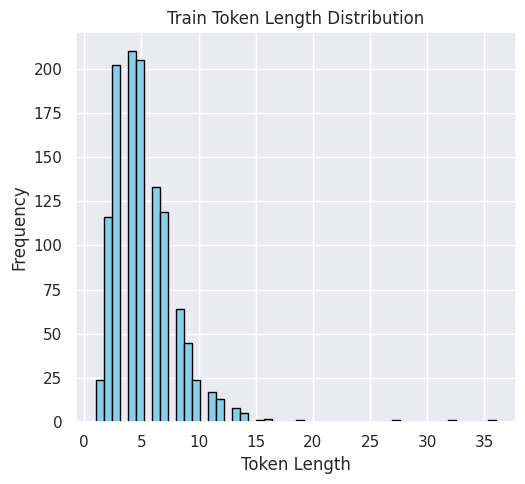

In [101]:
# 토큰 수 분포 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(train_token_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Train Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

* 먼저 테스트용 데이터에 대한 문장별 토큰수에 대해서 탐색적 분석을 시도한다.

In [102]:
# 각 문장의 토큰 수를 계산
test_token_lengths = [len(seq) for seq in test_sequences]

In [103]:
print('\n테스트 데이터:')
print('평균 토큰 수:', np.mean(test_token_lengths))
print('중앙값 토큰 수:', np.median(test_token_lengths))
print('최대 토큰 수:', np.max(test_token_lengths))
print('최소 토큰 수:', np.min(test_token_lengths))


테스트 데이터:
평균 토큰 수: 4.3584905660377355
중앙값 토큰 수: 4.0
최대 토큰 수: 13
최소 토큰 수: 2


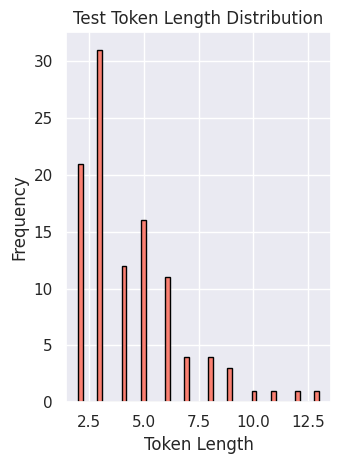

In [104]:
plt.subplot(1, 2, 2)
plt.hist(test_token_lengths, bins=50, color='salmon', edgecolor='black')
plt.title('Test Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

* 학습 입력을 위한 데이터 크기 맞추기 -> pad_sequences() 함수를 통해 통일
    * 문장이 짧기 때문에 MAX_SEQUENCE_LENGTH는 정하지 않아도 되지만,
    * 그러나 분포를 보고 적절하게 자릅시다.
    * 그리고 pad_sequences 함수를 이용하여 시퀀스데이터로 변환하기
* y는 train['type'] 와 test['type'] 입니다.

In [105]:
# 문장 길이 분포를 바탕으로 MAX_SEQUENCE_LENGTH 결정
MAX_SEQUENCE_LENGTH = 20 # 문장별 토큰 수를 최대 1000으로 설정하면 될 듯 싶다...

* 학습용 데이터 입니다.

In [106]:
# 시퀀스 데이터의 길이를 MAX_SEQUENCE_LENGTH에 맞추어 조정
X_train = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [109]:
X_train

array([[336,  84, 440, ...,   0,   0,   0],
       [440, 441,   0, ...,   0,   0,   0],
       [ 84, 336, 260, ...,   0,   0,   0],
       ...,
       [  3, 439,   2, ...,   0,   0,   0],
       [117,   4,   3, ...,   0,   0,   0],
       [  3, 136, 335, ...,   0,   0,   0]], dtype=int32)

In [107]:
y_train = train_df['type']

In [108]:
y_train.value_counts()

1    746
0    446
Name: type, dtype: int64

* 0과 1이 데이터 불균형이여서 0에 대해서 가중치를 더 부여하고자 한다.

In [110]:
from sklearn.utils.class_weight import compute_class_weight

In [111]:
# 클래스 레이블과 해당 레이블의 빈도수
labels = np.unique(y_train)
class_weight = compute_class_weight(class_weight='balanced', classes=labels, y=y_train)

# 클래스 가중치 딕셔너리 생성
class_weight_dict = {label: weight for label, weight in zip(labels, class_weight)}

In [112]:
class_weight_dict # 비교적 수가 적은 0에 더 가중치를 부여했다.

{0: 1.336322869955157, 1: 0.7989276139410187}

In [113]:
X_train.shape, y_train.shape

((1192, 20), (1192,))

* 테스트 데이터 입니다.

In [114]:
# 시퀀스 데이터의 길이를 MAX_SEQUENCE_LENGTH에 맞추어 조정
X_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [115]:
X_test

array([[  16,  680,  749, ...,    0,    0,    0],
       [  84,  686,  687, ...,    0,    0,    0],
       [ 444,  445,   25, ...,    0,    0,    0],
       ...,
       [ 105,  106,   36, ...,    0,    0,    0],
       [ 117,    4,    3, ...,    0,    0,    0],
       [   3, 1266,  439, ...,    0,    0,    0]], dtype=int32)

In [116]:
y_test = test_df['type'].astype(int) # 이게 왜 object인지는 모르겠지만 int로 변환해줍시다

In [117]:
X_test.shape, y_test.shape

((106, 20), (106,))

#### 2) 모델링

* 토크나이징 한 데이터를 입력으로 받아
* Embedding 레이어와 LSTM 레이어를 결합하여 이진 분류 모델링을 수행합니다.

* y_train에 class가 1이 746개, 0이 446개인데,
  모델을 학습할 떄 0에 가중치를 더 부여한다.

In [118]:
# 모델 구축
model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size + 1, output_dim=64, input_length=20))
model1.add(LSTM(64, return_sequences=True))
model1.add(Flatten()) # Embedding Layer 사용후 Flatten()을 해야 한다.
model1.add(Dense(64, activation='swish'))
model1.add(Dense(16, activation='swish'))
model1.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

Epoch 1/10
30/30 [==============================] - 13s 133ms/step - loss: 0.5157 - accuracy: 0.6516 - val_loss: 0.6520 - val_accuracy: 0.8201
Epoch 2/10
30/30 [==============================] - 2s 64ms/step - loss: 0.0476 - accuracy: 0.9874 - val_loss: 0.3851 - val_accuracy: 0.9163
Epoch 3/10
30/30 [==============================] - 1s 37ms/step - loss: 9.5409e-04 - accuracy: 0.9990 - val_loss: 0.1505 - val_accuracy: 0.9707
Epoch 4/10
30/30 [==============================] - 0s 16ms/step - loss: 6.3529e-05 - accuracy: 1.0000 - val_loss: 0.1466 - val_accuracy: 0.9749
Epoch 5/10
30/30 [==============================] - 1s 22ms/step - loss: 1.5263e-05 - accuracy: 1.0000 - val_loss: 0.1496 - val_accuracy: 0.9749
Epoch 6/10
30/30 [==============================] - 1s 22ms/step - loss: 1.2352e-05 - accuracy: 1.0000 - val_loss: 0.1540 - val_accuracy: 0.9707
Epoch 7/10
30/30 [==============================] - 1s 31ms/step - loss: 1.0460e-05 - accuracy: 1.0000 - val_loss: 0.1571 - val_accuracy

In [119]:
predictions = model1.predict(X_test) # sigmoid() 함수를 거치기 떄문에 0 ~ 1 범위의 값들이 존재할 것이다.
predicted_classes = np.where(predictions > 0.5, 1, 0).ravel() # ravel()를 사용해서 1차원 넘파이 배열로 변환

# 모델 평가
print("정확도: ", accuracy_score(y_test, predicted_classes)) # Series나 1차원 넘파이 배열 형태면 됩니다.

4/4 [==============================] - 0s 3ms/step
정확도:  0.9905660377358491


* Type(0, 일상대화)이냐 (1, 에이블스쿨 Q&A)이냐 잘 분류하고 있군요.

### (2) FastText 모델 : 사전학습된 Word2Vec 모델을 사용

-  FastText 모델 학습을 위한 입력 포맷 2차원 리스트 형태 입니다.
  ```
  [['나', '는', '학생', '이다'], ['오늘', '은', '날씨', '가', '좋다']]
  ```

- Word2Vec계열의 FastText를 학습하는 이유
  - n-gram이 추가된 fasttext 모델은 유사한 단어에 대한 임베딩을 word2vec보다 잘 해결할 수 있으며, 오탈자 등에 대한 임베딩 처리가 가능하다.
  - 예) 체크카드, 쳌카드는 word2vec에서는 전혀 다른 단어이지만 fasttext는 character n-gram으로 비교적 같은 단어로 처리할 수 있다.
- 참고: https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText


#### 1) 데이터 준비
* 시작데이터 : clean_train_questions, clean_test_questions

* FastText를 위한 입력 데이터 구조 만들기

#### 2) FastText 모델 생성
* FastText 문법
    * FastText( input데이터,  min_count = , size= , window=  )
        * input데이터 : 학습에 사용할 문장으로 이루어진 리스트 -> 2차원 리스트를 기대한다.
        * min_count : 모델에 사용할 단어의 최소 빈도수. 이 값보다 적게 출현한 단어는 모델에 포함되지 않음. 기본값 = 5
        * size : 단어의 벡터 차원 지정. 기본값 = 100
        * window : 학습할 때 한 단어의 좌우 몇 개의 단어를 보고 예측을 할 것인지를 지정. 기본값 = 5
    * 참조 : https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText

In [120]:
from gensim.models.fasttext import FastText
import gensim.models.word2vec

ft_model = FastText(clean_train_questions, # 입력 형태로 2차원 리스트를 기대한다.
                    vector_size=200,
                    window=3,
                    min_count=2,
                    workers=3,
                    sg=0)

#### 3) train에 임베딩벡터 결과 저장
* get_sent_embedding 함수를 이용하여 train의 질문별 임베딩 결과를 저장합니다.
    * .apply(lambda .....) 를 활용하세요.

In [121]:
rr = get_dataset(sentences=clean_train_questions, model=ft_model, num_features=ft_model.vector_size)

In [122]:
train_df['ft_vec'] = list(rr) # FastText로 임베딩한 결과물을 train_df의 새로운 변수 'ft_vec'에 추가

### (3) 챗봇 구축
- input 질문
- intent classifier로 common와 faq 중 하나를 예측
- 예측된 intent에 속한 train의 모든 Q와 input 문장의 임베딩 벡터간의 코사인 유사도 계산
- 코사인 유사도가 가장 높은 top-3개의 Q를 선택
- 선택한 Q에 맵핑된 답변 중 하나를 선택하고 실제 답변과 비교

#### 1) 하나의 질문으로 테스트해보기

* 선택된 질문과 답변

In [123]:
test_sample = test_df.sample(1) # 테스트 데이터 중에 임의로 1개 선택
q = test_sample['Q'] # 질문
i = test_sample['intent'] # intent
t = test_sample['type'] # type

In [124]:
print('질문 : ', q.values[0])
print('Intent : ', i.values[0])
print('type : ', t.values[0])

질문 :  핸드폰 맛 갔어
Intent :  1
type :  0


* 예측을 위한 입력 형태로 변환
  * Embedding + LSTM Layer에 사용했던 데이터 형태가 대충 예로 들면 (1566, 20), (32, 20) 형태여서
  사용자의 질문을 (?, 20) 형태로 만들어야 한다.

In [125]:
token_q = [okt.morphs(q.values[0])] # 2차원 리스트 형태로 만든다.
tokenized_sent_seq = tokenizer.texts_to_sequences(token_q)
tokenized_sent_input = pad_sequences(tokenized_sent_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [126]:
tokenized_sent_input.shape

(1, 20)

* 예측하기
  * 예측 Type이 0(일상 대화), Type이 1(에이블스쿨 지원 Q&A 대화)인지 판별

In [127]:
predictions = model1.predict(tokenized_sent_input) # sigmoid() 함수를 거치기 떄문에 0 ~ 1 범위의 값으로 존재할 것이다.
print(predictions)
pred_class = 1 if predictions > 0.5 else 0 # 일반적으로 0.5 초과이면 1로 판단, 미만이면 0으로 판단한다. 우리는 지금 그것을 한 것이다.

# 예측 Type 클래스 확인
  # 0이면 일상 대화
  # 1이면 에이블스쿨 Q&A 대화
print("예측 Type 클래스 : ", pred_class)

1/1 [==============================] - 0s 17ms/step
[[1.994216e-06]]
예측 Type 클래스 :  0


* 질문에 대한 벡터 만들기
    * FestText 모델로 부터 벡터 만들기

In [128]:
test_question_ft = get_dataset(sentences=token_q, model=ft_model, num_features=ft_model.vector_size)

In [129]:
test_question_ft.shape # 2차원 넘파이 배열 형태

(1, 200)

* train의 질문 벡터들과 유사도 계산
    * FastText 로 만들 벡터들과 유사도 계산
       * 사용자의 질문과 ft_vec 모두 2차원 넘파이 배열을 기대한다.

In [130]:
from sklearn.metrics.pairwise import cosine_similarity

In [131]:
# 예측 Type 클래스를 0으로 했으면 Type 클래스가 0인 데이터에서만 코사인 유사도 계산, 반대로 Type 클래스를 1로 했으면 Type 클래스가 1인 데이터에서만 코사인 유사도 계산
temp_df = train_df.loc[train_df['type'] == pred_class]

temp_df['cosine_ft'] = temp_df['ft_vec'].apply(lambda x : cosine_similarity(test_question_ft, [x])[0][0])

<ipython-input-131-724a7ef7f075>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['cosine_ft'] = temp_df['ft_vec'].apply(lambda x : cosine_similarity(test_question_ft, [x])[0][0])


* 'cosine_ft'가 가장 높은 것에 대한 Answer를 찾아 랜덤하게 프린트하여 보여준다.

In [132]:
temp_df = temp_df.sort_values(by='cosine_ft', ascending=False,)

In [133]:
head_intent = temp_df.head(1)['intent'].iloc[0] # intent를 찾기 위함

In [134]:
random.choice(temp_df.loc[temp_df['intent'] == head_intent, 'A'].tolist())

'조심하세요.'

#### 2) 함수로 생성하기

In [136]:
def get_answer2(question):
    # 0. 맞춤법 정리
      # 원래는 맞춤법 정리도 하려고 했지만, Hanspell이 말을 안들어서(서버 오류인지... 잘 모르겠음)
      # 저도 아직 못하고 있었답니다. 관심이 있으신분들은 한번 해보십쇼. 하지만 안해도 크게 지장은 없습니다.

    # 1. 특수 문자 제거
    removal_list =  "‘’◇‘”’'·\“·△●■()\">>`/-∼=ㆍ<>.?!【】…◆%"
    removal_list += string.punctuation

    question_1 = re.sub("[.,\'\"’‘”“!?]", "", question)
    question_2 = re.sub("[^가-힣0-9a-zA-Z\\s]", " ", question_1)
    question_3 = re.sub("\s+", " ", question_2)

    question_4 = question_3.translate(str.maketrans(removal_list, ' '*len(removal_list)))
    question_5 = question_4.strip()

    # 1.5. 텍스트를 형태소 단위로 분리
    question_6 = okt.morphs(question_5)

    # 2. 한글 불용어 처리(자신만의 한글 불용어 txt 파일을 만들어서 경로 바꾸고 적용해보십쇼!, 만약 하고싶지 않으시면, 2번은 주석 처리 하십쇼!)
    korean_stopwords = []
    for fileName in ['koreanStopwords.txt', 'stopwords.txt', 'stopword2.txt', 'stopword3.txt', 'stopword4.txt']:
        f = open(f'/content/drive/MyDrive/미니프로젝트6차part1/데이터/한국어불용어사전/{fileName}', 'r')
        lines = f.readlines()
        for line in lines:
            line = line.replace('\n', '')
            line = line.replace('\t', '')
            korean_stopwords.append(line)
        f.close()
    korean_stopwords = list(set(korean_stopwords))
    question_7 = [morph for morph in question_6 if morph not in korean_stopwords]  # 한글 불용어 제거

    # 3. sentence를 2차원 리스트로 만듦 -> Embdding + LSTM를 이용해서 Type(0), Type(1)를 예측하는 모델에 적합한 입력 형태로 만듦
    question_8 = [question_7]
    question_9 = tokenizer.texts_to_sequences(question_8)
    question_10 = pad_sequences(question_9, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

    # 4. 모델 1에 predict하여 예측 클래스가 Type(0)인지 Type(1)인지 확인한다.
    predictions = model1.predict(question_10) # sigmoid() 함수를 거치기 떄문에 0 ~ 1 범위의 값으로 존재할 것이다.
    pred_class = 1 if predictions > 0.5 else 0 # 일반적으로 0.5 초과이면 1로 판단, 미만이면 0으로 판단한다. 우리는 지금 그것을 한 것이다.

    # 5. fastText 모델을 도입한다.
    ft_model = FastText(clean_train_questions, # 입력 형태로 2차원 리스트를 기대한다.
                    vector_size=200,
                    window=3,
                    min_count=2,
                    workers=3,
                    sg=0)

    # 6. train에 있었던 질문에 대해서 FastText를 이용해서 임베딩, 벡터화 하는 작업을 한다.
    rr = get_dataset(sentences=clean_train_questions,
                     model=ft_model,
                     num_features=ft_model.vector_size)
    train_df['ft_vec'] = list(rr) # FastText로 임베딩한 결과물을 train_df의 새로운 변수 'ft_vec'에 추가

    # 7. 사용자가 입력한 질문에 대해서 FastText를 이용해서 임베딩, 벡터화 작업 한다.
    question_11 = get_dataset(sentences=question_8, model=ft_model, num_features=ft_model.vector_size)

    # 8. 예측 Type 클래스를 0으로 했으면 Type 클래스가 0인 데이터에서만 코사인 유사도 계산, 반대로 Type 클래스를 1로 했으면 Type 클래스가 1인 데이터에서만 코사인 유사도 계산
    temp_df = train_df.loc[train_df['type'] == pred_class]
    temp_df['cosine_ft'] = temp_df['ft_vec'].apply(lambda x : cosine_similarity(question_11, [x])[0][0])

    # 9. 코사인 유사도 결과, 가장 높은 값으로 내림차순 정렬 후 가장 맨 1번쨰의 intent를 구하고 그에 대한 Answer를 랜덤하게 return
    temp_df = temp_df.sort_values(by='cosine_ft', ascending=False, )
    head_intent = temp_df.head(1)['intent'].iloc[0] # intent를 찾기 위함
    return random.choice(temp_df.loc[temp_df['intent'] == head_intent, 'A'].tolist())

In [140]:
test_sample = test_df.sample(1) # 테스트 데이터 중에 임의로 1개 선택
print('*' * 100)
print('질문 : ', test_sample['Q'].values[0])
print('*' * 100)
print('대답 : ', get_answer2(test_sample['Q'].values[0])) # '차 너무 막혀' 이런 식으로 데이터가 들어간다.
print('*' * 100)

****************************************************************************************************
질문 :  소개팅 해볼까
****************************************************************************************************
1/1 [==============================] - 0s 19ms/step
대답 :  로맨틱하네요.
****************************************************************************************************


<ipython-input-136-8a37418a5170>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['cosine_ft'] = temp_df['ft_vec'].apply(lambda x : cosine_similarity(question_11, [x])[0][0])


#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [ ]:
# 실제값과 예측값
y_true = test_df['intent'].astype(int) # 실제값, Series 형태
y_pred = [] # 예측값

In [ ]:
predictions = model1.predict(X_test) # sigmoid() 함수를 거치기 떄문에 0 ~ 1 범위의 값들이 존재할 것이다.
predicted_classes = np.where(predictions > 0.5, 1, 0).ravel() # flatten()를 사용해서 1차원 넘파이 배열로 변환

# 모델 평가
print("정확도: ", accuracy_score(y_test, predicted_classes)) # Series나 1차원 넘파이 배열 형태면 됩니다.

4/4 [==============================] - 0s 3ms/step
정확도:  0.9905660377358491


In [ ]:
# 예측한 Type 클래스 106개를 for문으로 돈다.
for idx, pc in enumerate(predicted_classes):
    txt = test_df.iloc[idx]['Q'] # test_df에 있는 'Q'를 순차적으로 가져온다.
    txt = [okt.morphs(txt)] # 형태소 분석 후 2차원 리스트로 만듦
    txt = get_dataset(sentences=txt, model=ft_model, num_features=ft_model.vector_size)  # FastText를 이용하여 임베딩, 벡터화 작업을 한다.

    if pc == 0: # 예측한 Type 클래스가 0이었을 떄
        temp_df = train_df.loc[train_df['type'] == 0]
    else: # 예측한 Type 클래스가 1이었을 떄
        temp_df = train_df.loc[train_df['type'] == 1]

    # 사용자가 입력한 질문 txt와 train에 있는 질문을 FastText로 임베딩, 벡터화 한 'ft_vec'과 코사인 유사도를 체크한다.
    temp_df['cosine_ft'] = temp_df['ft_vec'].apply(lambda x : cosine_similarity(txt, [x])[0][0])

    # 코사인 유사도 결과, 가장 높은 값으로 내림차순 정렬 후 가장 맨 1번쨰의 intent를 구한다.
    temp_df = temp_df.sort_values(by='cosine_ft', ascending=False, )
    head_intent = temp_df.head(1)['intent'].iloc[0] # intent를 찾기 위함

    # y_pred에 예측값을 append한다.
    y_pred.append(head_intent)

<ipython-input-103-6009b57bd790>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['cosine_ft'] = temp_df['ft_vec'].apply(lambda x : cosine_similarity(txt, [x])[0][0])
<ipython-input-103-6009b57bd790>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['cosine_ft'] = temp_df['ft_vec'].apply(lambda x : cosine_similarity(txt, [x])[0][0])
<ipython-input-103-6009b57bd790>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [ ]:
# 실제값과 예측값을 비교해서 정확도 계산
print('정확도 : ', accuracy_score(y_true, np.array(y_pred))) # 1차원 넘파이 배열 혹은 Series 여야 한다.

정확도 :  0.6981132075471698


## 5.질문에 대한 답변 비교해보기

* **세부요구사항**
    * 세가지 챗봇을 생성해 보았습니다.
    * 질문을 입력하여 답변을 비교해 봅시다. 어떤 챗봇이 좀 더 정확한 답변을 하나요?


In [145]:
test_sample = test_df.sample(1) # 테스트 데이터 중에 임의로 1개 선택
print('*' * 100)
print('질문 : ', test_sample['Q'].values[0])
print('*' * 100)
print('챗봇 1 대답 : ', get_answer1(test_sample['Q'].values[0])) # '차 너무 막혀' 이런 식으로 데이터가 들어간다.
print('*' * 100)
print('챗봇 2 대답 : ', get_answer2(test_sample['Q'].values[0])) # '차 너무 막혀' 이런 식으로 데이터가 들어간다.
print('*' * 100)

****************************************************************************************************
질문 :  대면 필요한 부분 도 있나요
****************************************************************************************************
챗봇 1 대답 :  비전공자도 SW개발에 관심과 열정이 있으신 분들은 충분히 따라 갈 수 있습니다.  
이 경우 데이터 사이언스 기반으로 산업 현장에 AI를 접목하고 DX를 이끄는 DX컨설턴트 Track을 추천 드립니다.  
SW기초 지식 및 코딩역량을 보유하고 있고 개발자로 성장하고 싶은 분께는 AI개발자 Track을 추천 드립니다. 

파이썬 프로그래밍 사용법과 AI 개념에 대한 기초 이해를 공부하고 오시면 도움이 되실 것 같습니다.
****************************************************************************************************
1/1 [==============================] - 0s 17ms/step
챗봇 2 대답 :  교육 과정 중 STEP1과 STEP2는 대부분 비대면 교육으로 진행하며, 일부 프로젝트는 대면으로 진행될 수 있습니다. STEP3 프로젝트 수행기간에는 대면 & 비대면을 병행하여 진행합니다. (단, 코로나 정부방역지침에 따라 변경될 수 있습니다.)
****************************************************************************************************


<ipython-input-136-8a37418a5170>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['cosine_ft'] = temp_df['ft_vec'].apply(lambda x : cosine_similarity(question_11, [x])[0][0])


* 보기에도 챗봇 1보다 챗봇 2가 더 우수한 성능을 보이는 것을 알 수 있다.